Cards  0 1
great match:  6 6   0.057072143475225184
great match:  7 2   0.09703086935590216
best_match =  (6, 6) min_diff =  0.057072143475225184
Cards  0 2
great match:  7 6   0.02544563428762947
best_match =  (7, 6) min_diff =  0.02544563428762947
Cards  0 3
great match:  3 7   0.01350890955799719
best_match =  (3, 7) min_diff =  0.01350890955799719
Cards  1 2
great match:  4 2   0.015553967275448777
best_match =  (4, 2) min_diff =  0.015553967275448777
Cards  1 3
great match:  5 0   0.01875016129956031
best_match =  (5, 0) min_diff =  0.01875016129956031
Cards  2 3
great match:  1 5   0.09726758090117671
great match:  3 2   0.030929527872501722
best_match =  (3, 2) min_diff =  0.030929527872501722


ValueError: zero-size array to reduction operation minimum which has no identity

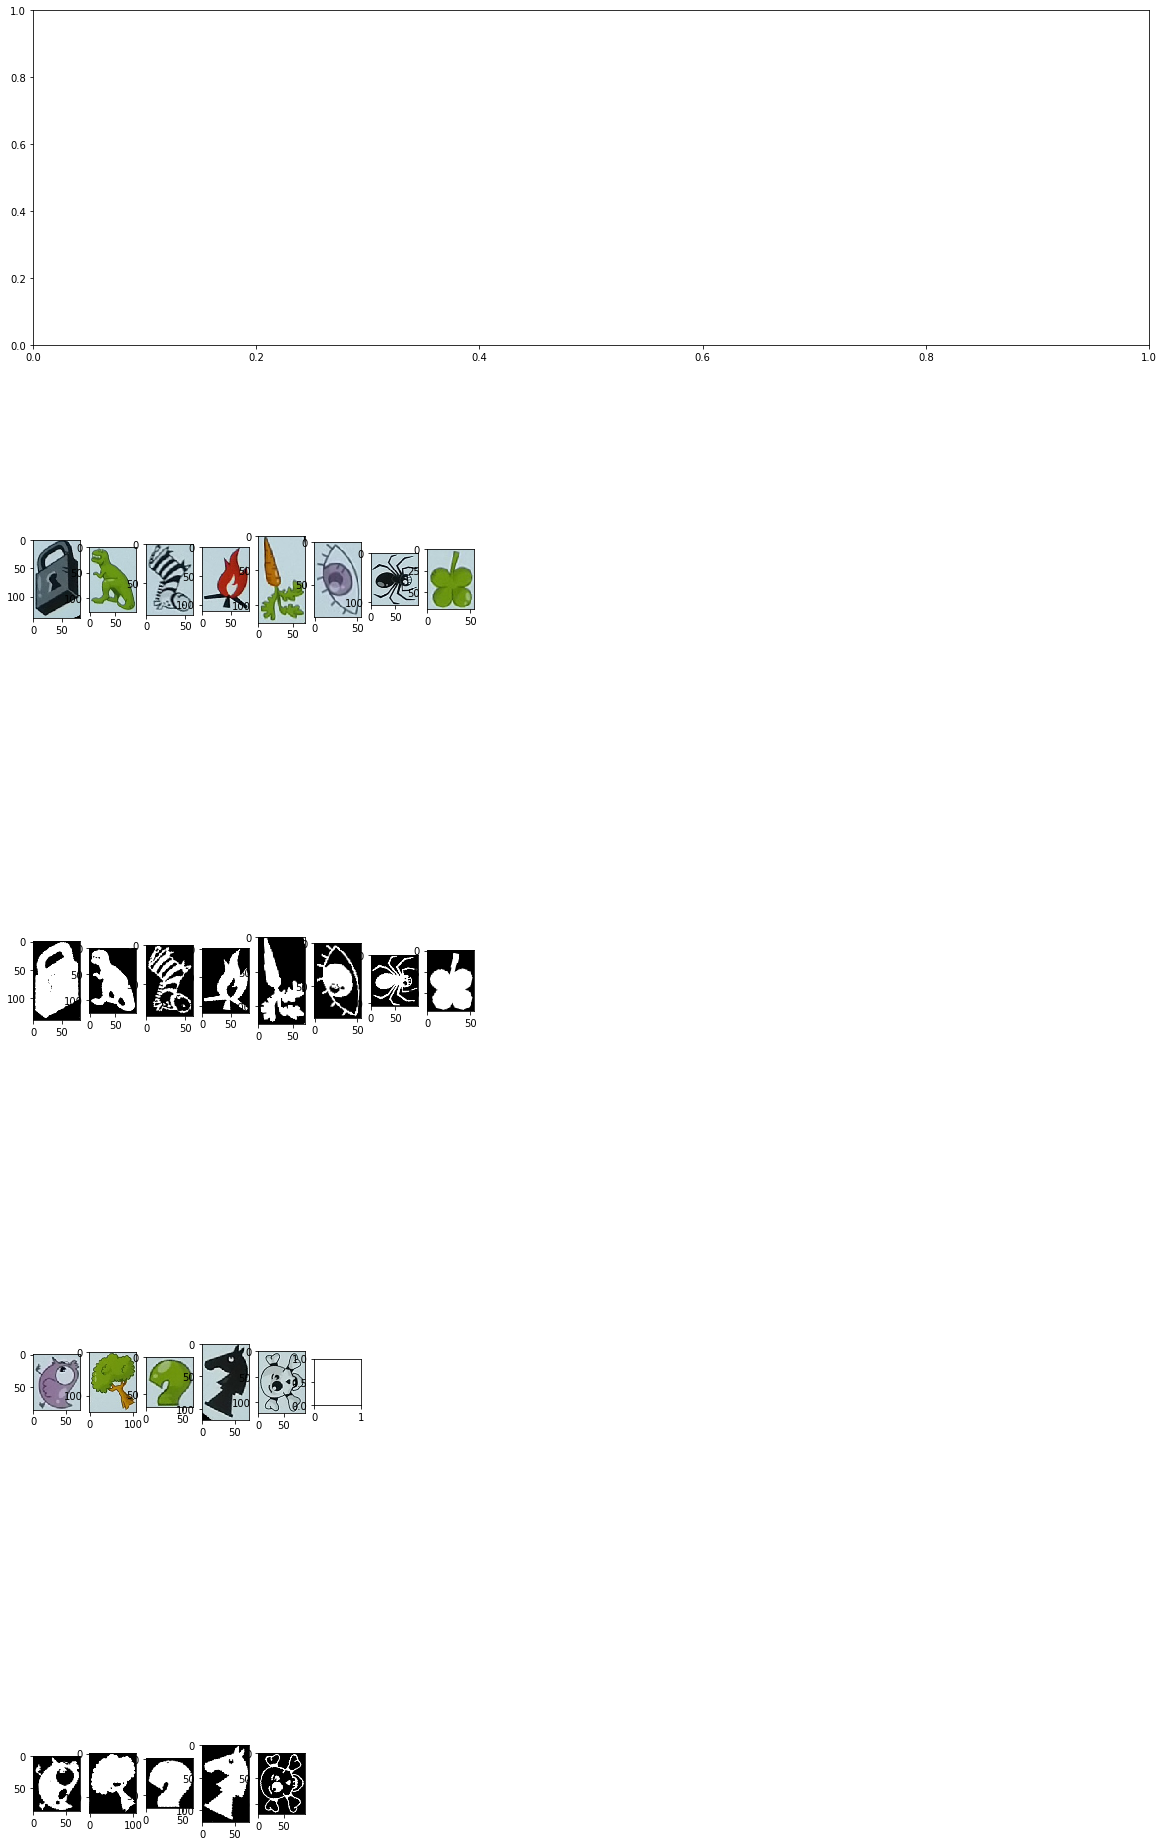

In [236]:
import matplotlib.gridspec as gridspec
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
import warnings
from random import randint
from sklearn.cluster import KMeans

def gamma_filter(img):
    MIN = 152
    MAX = 167
    gamma_MIN = 1.0
    gamma_MAX = 1.3
    mean = np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    gamma = (MAX - mean)*((gamma_MAX - gamma_MIN)/(MAX-MIN)) + gamma_MIN
    
    invGamma = 1.0/gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def coords(contour, i):
    xmin = int(np.amin(contour[:,0,1]))
    xmax = int(np.amax(contour[:,0,1]))
    ymin = int(np.amin(contour[:,0,0]))
    ymax = int(np.amax(contour[:,0,0]))
    return xmin-i, xmax+i, ymin-i, ymax+i
    
# def measure(contour):
#     xmin, xmax, ymin, ymax = coords(contour, 0)
#     return xmax-xmin,ymax-ymin

def draw_arrow(p1, p2):
    cv2.arrowedLine(img_arrows, (int(p1[0]), int(p1[1])), (int(p2[0]), int(p2[1])), (randint(0, 255), randint(0, 255), randint(0, 255)), 5)

# # Policz sumę wartości bezwzględnych różnic pomiędzy odpowiadającymi elementami tablic 
# def calculate_diff(arr1, arr2):
# 	return sum(list(map(float.__abs__, list(map(float.__sub__, arr1, arr2)))))

# def match_ratio(card1, card2):
# 	ratios1 = []
# 	ratios2 = []
# 	for sign in card1["signs"]:
# 		ratios1.append(len(sign['pic'][0]) / len(sign['pic'])) 
# 	for sign in card2["signs"]:
# 		ratios2.append(len(sign['pic'][0]) / len(sign['pic'])) 
# 	best_match = (0, 0)
# 	min_diff = abs(ratios1[0]-ratios2[0])
# 	for i in range(len(ratios1)):
# 		# for j in range(i, len(ratios2)):
# 		for j in range(len(ratios2)):
# 			if (abs(ratios1[i]-ratios2[j]) < min_diff):
# 				min_diff = abs(ratios1[i]-ratios2[j])
# 				best_match = (i, j)
# 	p1 = card1["signs"][best_match[0]]['coords']
# 	p2 = card2["signs"][best_match[1]]['coords']
# 	print('ratios1 = ', ratios1, '\nratios2 = ', ratios2)
# 	print('best_match = ', best_match, 'min_diff = ', min_diff)
# 	print('p1 = ', p1, ', p2 = ', p2)
# 	draw_arrow(p1, p2)

# def match_hu(card1, card2):
# 	hu1 = []
# 	hu2 = []
# 	for sign in card1["signs"]:
# 		hu1.append(cv2.HuMoments(cv2.moments(cv2.cvtColor(sign['pic'], cv2.COLOR_BGR2GRAY))).flatten()) 
# 	for sign in card2["signs"]:
# 		hu2.append(cv2.HuMoments(cv2.moments(cv2.cvtColor(sign['pic'], cv2.COLOR_BGR2GRAY))).flatten())
# 	best_match = (0, 0)
# 	min_diff = calculate_diff(hu1[0], hu2[0])
# 	for i in range(len(card1['signs'])):
# 		for j in range(len(card2['signs'])):
# 			if(calculate_diff(hu1[i], hu2[i]) < min_diff):
# 				min_diff = calculate_diff(hu1[i], hu2[i])
# 				best_match = (i, j)
# 	p1 = card1["signs"][best_match[0]]['coords']
# 	p2 = card2["signs"][best_match[1]]['coords']
# 	print('hu1 = ', hu1, '\nhu2 = ', hu2)
# 	print('best_match = ', best_match, 'min_diff = ', min_diff)
# 	print('p1 = ', p1, ', p2 = ', p2)
# 	draw_arrow(p1, p2)
    

def match_hu_janek(card1, card2):
    best_match = (0, 0)
    min_diff = 1
    for i in range(len(card1['signs'])):
        for j in range(len(card2['signs'])):
            hu_moment = cv2.matchShapes(card1["signs"][i]["contour"],
                                        card2["signs"][j]["contour"], 1, 0.0)  # różnica w obiektach
            if(hu_moment < min_diff):
                min_diff = hu_moment
                best_match = (i, j)
            if(hu_moment < 0.1): 
                print("great match: ", i, j, " ", hu_moment)
    p1 = card1["signs"][best_match[0]]['coords']
    p2 = card2["signs"][best_match[1]]['coords']
    print('best_match = ', best_match, 'min_diff = ', min_diff)
    draw_arrow(p1, p2)

    
def findMinRectangle(img_col, contour, offset):
    rect = cv2.minAreaRect(contour)
    rotated = cv2.warpAffine(img_col, cv2.getRotationMatrix2D(rect[0],rect[2],1), img_col.shape[1::-1])
    cropped = rotated[int(rect[0][1]-rect[1][1]/2)-offset:int(rect[0][1]+rect[1][1]/2+offset),
                      int(rect[0][0]-rect[1][0]/2)-offset:int(rect[0][0]+rect[1][0]/2+offset)]
    xwidth, ywidth = cropped.shape[0:2]
    if(xwidth < ywidth): cropped = np.rot90(cropped, 1)
    return cropped, rect[0]

def getRGBthresh(img_col, blue, green, red):
    ret1, img_red_th = cv2.threshold(img_col[:,:,0], blue, 255, cv2.THRESH_BINARY_INV)
    ret2, img_green_th = cv2.threshold(img_col[:,:,1], green, 255, cv2.THRESH_BINARY_INV)
    ret3, img_blue_th = cv2.threshold(img_col[:,:,2], red, 255, cv2.THRESH_BINARY_INV)
    img_th =  cv2.bitwise_or(cv2.bitwise_or(img_red_th, img_green_th, mask=None), img_blue_th, mask=None)
    return img_th

def eraseBackground(img, contours):     #jak zmienić tło na białe 
    stencil = np.zeros(img.shape).astype(img.dtype)
    cv2.fillPoly(stencil, contours, [255, 255, 255])
    result = cv2.bitwise_and(stencil, img)
    return result

            
file = './img/dobble02.jpg'

img_col = cv2.imread(file)
img_gray = cv2.cvtColor(img_col, cv2.COLOR_BGR2GRAY)
img_col = cv2.cvtColor(img_col, cv2.COLOR_BGR2RGB)
img_arrows = img_col

warnings.simplefilter("ignore")

cards = []

if (np.mean(img_gray) < 150):  #dla wszystkich zdjęć bez białego tła
    
    #znalezienie konturów kart i wyczyszczenie tła dookoła
    ret, th1 = cv2.threshold(img_gray, 115, 255, cv2.THRESH_BINARY)
    th1 = cv2.erode(th1,np.ones((3,3),np.uint8),iterations = 3)
    th1 = cv2.dilate(th1, np.ones((3,3),np.uint8), iterations = 2)
    im2, contours, hierarchy = cv2.findContours(th1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_no_background = eraseBackground(img_col, contours)
    
    #wycięcie kart 
    for i, contour in enumerate(contours):
        cxmin, cxmax, cymin, cymax = coords(contour, -5)
        if (cxmax-cxmin > 100 or cymax-cymin > 100):
            card = img_no_background[cxmin:cxmax,cymin:cymax]
            
            cardRGBthresh = getRGBthresh(card, 150, 130, 130)
            
            cv2.imwrite("./th" + str(i) + ".jpg", cardRGBthresh)
            im2, contours, hierarchy = cv2.findContours(cardRGBthresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
            #wycięcie znaków z kart
            signList = []
            for signContour in contours:
                sxmin, sxmax, symin, symax = coords(signContour, 0)
                if ((sxmax-sxmin > 40 or symax-symin > 40) and not (sxmin < 10 or symin < 10 or sxmax > card.shape[0]-10)):
                    signPic, centerCoords = findMinRectangle(card, signContour, 3)
                    signThPic, c = findMinRectangle(cardRGBthresh, signContour, 3)
                    coordx =  centerCoords[1] + cxmin
                    coordy =  centerCoords[0] + cymin
                    cv2.putText(img_arrows, str(len(signList)), (int(coordy), int(coordx)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 51, 153), 4) # zapisywanie numeru symbolu na zdjęciu
                 
                    # wyciąć background poza konturem 
                    signList.append({"pic": signPic, "th": signThPic, "contour": signContour, "coords": [coordy, coordx]})
            
            cards.append({"pic": card, "signs": signList})


else:    # dla zdjęć z białym tłem
    
    img_col = gamma_filter(img_col)
    img_th = getRGBthresh(img_col, 150, 130, 130)  # treshhold po RGB
    img_th = cv2.dilate(img_th ,np.ones((3,3),np.uint8),iterations = 2)
    im2, contours, hierarchy = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_th = cv2.erode(img_th ,np.ones((3,3),np.uint8),iterations = 2)

    #znalezienie poprawnych znaków na zdjęciu
    signsCenters = []
    properContours = []
    for contour in contours:
        xmin, xmax, ymin, ymax = coords(contour, 0)
        if (xmax-xmin > 50 and ymax-ymin > 50 and xmax-xmin < 300 and not (xmin < 200 and ymax > 1400)):
            signsCenters.append([(xmax+xmin)/2, (ymax+ymin)/2])
            properContours.append(contour)

    #pogrupowanie znaków w karty
    signsIdentity = KMeans(n_clusters=int(len(signsCenters)/8), random_state=0).fit(signsCenters).labels_  
    for k in range(int(len(signsCenters)/8)):
        signsContours = [contour for j, contour in enumerate(properContours) if signsIdentity[j] == k]
        signsList = []
        for signContour in signsContours:
            signPic, centerCoords = findMinRectangle(img_col, signContour, 0)
            signThPic, c = findMinRectangle(img_th, signContour, 0)
            cv2.putText(img_arrows, str(len(signsList)), (int(centerCoords[0]), int(centerCoords[1])), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 51, 153), 4) # zapisywanie numeru symbolu na zdjęciu
            signsList.append({"pic": signPic, "th": signThPic, "contour": signContour, "coords": centerCoords})
        cards.append({"pic": None, "signs": signsList})
        
        #TODO wycięcie karty, niekoniecznie potrzebne, ale fajne do debugu

        
fig = plt.figure(figsize=(20, 80))
gs = gridspec.GridSpec(2*5+1, 20, wspace=0.2, hspace=0.2)
ax = plt.subplot(gs[0,:])

# ax = plt.subplot(111)	# do dokładnego testowania zdjęcia w konsoli (wyświetlanie tylko jednego)

#calculate differences and pick best match
for i in range(len(cards)):
    for j in range(i+1, len(cards)):
        # match_ratio(cards[i], cards[j])
        # match_hu(cards[i], cards[j])
        print("Cards ", i, j)
        match_hu_janek(cards[i], cards[j])
        
cv2.imwrite( "./img_arrows.jpg", cv2.cvtColor(img_arrows, cv2.COLOR_BGR2RGB));
# ax.imshow(img_arrows)   
# fig.add_subplot(ax)

for j, card in enumerate(cards):
# #     ax = plt.subplot(gs[j, :])
# #     ax.imshow(card["pic"])
# #     fig.add_subplot(ax)

    for i, sign in enumerate(card["signs"]):
        ax = plt.subplot(gs[2*j+1, i])
        ax.imshow(sign["pic"])
        fig.add_subplot(ax)
        
        ax = plt.subplot(gs[2*j+2, i])
        ax.imshow(sign["th"], 'gray')
        fig.add_subplot(ax)       
        
plt.show()


# ax[0].imshow(cv2.cvtColor(img_col, cv2.COLOR_BGR2RGB))
# ax[1].hist(img.flatten(),256,[0,256], color = 'r')
# for i in range(2,4):
#     ax[i].imshow(images[i-2],'gray')

# for i, pic in enumerate(cards):
#     ax[i+4].imshow(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))
    
# for i, pic in enumerate(signs):
#     ax[i+1].imshow(cv2.cvtColor(pic["pic"], cv2.COLOR_BGR2RGB))
#     ax[i+1].set_title(pic["card"])